# Summarizing jobs' descriptions to titles

## About
The encoder-decoder architecture from BART models have proven to be extremely useful for text-summarization tasks. In this notebook I attempt to summarize [LinkedIn jobs posts](https://www.kaggle.com/datasets/arshkon/linkedin-job-postings) descriptions to its original titles using the BART-Base checkpoint.

## Imports

In [1]:
# !pip install datasets evaluate rouge_score transformers transformers[torch] bitsandbytes

In [2]:
import os
from copy import deepcopy
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
from pathlib import Path

from sklearn.model_selection import train_test_split

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", 
              style="white")

from datasets import Dataset
import evaluate
from transformers import (BartTokenizer,
                          BartForConditionalGeneration,
                          DataCollatorForSeq2Seq,
                          EarlyStoppingCallback,
                          Seq2SeqTrainingArguments,
                          Seq2SeqTrainer, 
                          get_scheduler)
import torch
import bitsandbytes as bnb

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Path to data
path = "/kaggle/input/linkedin-job-postings/job_postings.csv"

# Read the data
df = pd.read_csv(path)
df.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
0,85008768,NaN,Licensed Insurance Agent,While many industries were hurt by the last fe...,52000.0,NaN,45760.0,YEARLY,Full-time,"Chico, CA",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,1,FULL_TIME,USD,BASE_SALARY
1,133114754,77766802.0,Sales Manager,Are you a dynamic and creative marketing profe...,NaN,NaN,NaN,NaN,Full-time,"Santa Clarita, CA",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,FULL_TIME,NaN,NaN
2,133196985,1089558.0,Model Risk Auditor,Join Us as a Model Risk Auditor – Showcase You...,NaN,NaN,NaN,NaN,Contract,"New York, NY",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,CONTRACT,NaN,NaN
3,381055942,96654609.0,Business Manager,Business ManagerFirst Baptist Church ForneyFor...,NaN,NaN,NaN,NaN,Full-time,"Forney, TX",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,FULL_TIME,NaN,NaN
4,529257371,1244539.0,NY Studio Assistant,YOU COULD BE ONE OF THE MAGIC MAKERS\nKen Fulk...,NaN,NaN,NaN,NaN,Full-time,"New York, NY",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,1,FULL_TIME,NaN,NaN


# Preprocessing

## Missing values

In [5]:
df.shape

(15886, 27)

In [6]:
# NaNs count - Only on the columns we're interested in which are 'title' and 'description'
df[["title", "description"]].isnull().sum()

title          0
description    1
dtype: int64

In [7]:
# Check where the NaNs are
nans_mask = (df["title"].isnull()) | (df["description"].isnull())
df.loc[nans_mask]

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
6252,3694104501,157262.0,Senior Universal Banker,NaN,NaN,NaN,NaN,NaN,Full-time,Nashville Metropolitan Area,...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,FULL_TIME,NaN,NaN


In [8]:
# Drop NaNs
print(f"Rows before: {df.shape[0]}")
df = df[~nans_mask].reset_index(drop=True).copy(deep=True)
print(f"Rows after: {df.shape[0]}")

Rows before: 15886
Rows after: 15885


## Text preprocessing

### Titles with special characters

In [9]:
def has_special_char(text: str) -> bool:
    return any(c for c in text if not c.isalnum() and not c.isspace())

df.loc[df["title"].apply(lambda x: has_special_char(x))]

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
8,1029078768,61469.0,Registered Nurse (RN) Vaccinator,United Staffing Solutions is partnering with o...,50.0,NaN,50.0,HOURLY,Part-time,"Muskegon, MI",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,PART_TIME,USD,BASE_SALARY
10,1418582485,NaN,Commercial Property Manager/Senior Property Ma...,Join Our Growing Property Management Team!\nLo...,NaN,NaN,NaN,NaN,Full-time,"Las Vegas, NV",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,FULL_TIME,NaN,NaN
13,1657978824,89350959.0,"REMOTE STEEL BUILDING SALES MAKE $1,000 TO $30...","REMOTE WORK FROM HOME $1,000 TO $10,000 COMMIS...",12000.0,NaN,12000.0,MONTHLY,Contract,"Texas, United States",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,CONTRACT,USD,BASE_SALARY
15,2148434014,1016.0,"Virtual Sales Associate Account Manager, Women...",Job Description Summary \n\nAs the Virtual Sal...,NaN,NaN,NaN,NaN,Full-time,"Maine, United States",...,1.700000e+12,NaN,Entry level,NaN,1.690000e+12,jobs.gecareers.com,0,FULL_TIME,NaN,NaN
16,2148434019,1016.0,"Virtual Sales Associate Account Manager, Women...",Job Description Summary \n\nAs the Virtual Sal...,NaN,NaN,NaN,NaN,Full-time,"Connecticut, United States",...,1.700000e+12,NaN,Entry level,NaN,1.690000e+12,jobs.gecareers.com,0,FULL_TIME,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15868,3701373382,16163783.0,"Customer Care Executive - Remote - Arizona, Co...",Love Your Mondays again!\nCustomer Care Execut...,NaN,17.0,NaN,HOURLY,Full-time,"New Mexico, United States",...,1.700000e+12,NaN,Mid-Senior level,NaN,1.690000e+12,recruiting2.ultipro.com,0,FULL_TIME,USD,BASE_SALARY
15871,3701373391,1839577.0,Math Content Tester (Freelance),"IXL Learning, a leading edtech company with pr...",NaN,NaN,NaN,NaN,Full-time,United States,...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,www.ixl.com,1,FULL_TIME,NaN,NaN
15876,3701373490,26205.0,"An, Database Developer","Description\nAn, Database Developer AFA / ISD ...",NaN,NaN,NaN,NaN,Full-time,"Oklahoma, United States",...,1.700000e+12,NaN,Associate,NaN,1.690000e+12,www.hrapply.com,0,FULL_TIME,NaN,NaN
15877,3701373493,5619.0,Sr. Bilingual Copywriter (Canadian French),Overview\nTHE ROLE:\nThe Senior Bilingual Copy...,105200.0,NaN,91900.0,YEARLY,Full-time,"Torrance, CA",...,1.700000e+12,NaN,Mid-Senior level,NaN,1.690000e+12,herbalifecareers.ttcportals.com,0,FULL_TIME,USD,BASE_SALARY


### Titles with "-" or ","

Looks like titles with slashes or commas mostly have the format *{actual position} - {extra info}*. The extra info should be placed into the 'description' column, but let's just ignore it.

In [10]:
df.loc[(df["title"].str.contains("-")) | ((df["title"].str.contains(",")))]

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
13,1657978824,89350959.0,"REMOTE STEEL BUILDING SALES MAKE $1,000 TO $30...","REMOTE WORK FROM HOME $1,000 TO $10,000 COMMIS...",12000.0,NaN,12000.0,MONTHLY,Contract,"Texas, United States",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,CONTRACT,USD,BASE_SALARY
15,2148434014,1016.0,"Virtual Sales Associate Account Manager, Women...",Job Description Summary \n\nAs the Virtual Sal...,NaN,NaN,NaN,NaN,Full-time,"Maine, United States",...,1.700000e+12,NaN,Entry level,NaN,1.690000e+12,jobs.gecareers.com,0,FULL_TIME,NaN,NaN
16,2148434019,1016.0,"Virtual Sales Associate Account Manager, Women...",Job Description Summary \n\nAs the Virtual Sal...,NaN,NaN,NaN,NaN,Full-time,"Connecticut, United States",...,1.700000e+12,NaN,Entry level,NaN,1.690000e+12,jobs.gecareers.com,0,FULL_TIME,NaN,NaN
19,2148434077,88016.0,Transporter - Full Time Evenings 3pm-11pm; Rot...,Service / Ancillary Staff --> Housekeeping\nPa...,NaN,NaN,NaN,NaN,Full-time,"Patchogue, NY",...,1.700000e+12,NaN,Entry level,NaN,1.690000e+12,jobs.silkroad.com,0,FULL_TIME,NaN,NaN
21,2148434265,34218836.0,Locum Critical Care Physician Assistant job in...,Aya Locums has an immediate opening for a 13-w...,NaN,NaN,NaN,NaN,Full-time,"Atlanta, GA",...,1.700000e+12,NaN,Mid-Senior level,NaN,1.690000e+12,www.ayalocums.com,0,FULL_TIME,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15864,3701373317,15259054.0,Equipment Maintenance Technician- Automotive P...,An international manufacturer of automotive pa...,30.0,NaN,20.0,HOURLY,Full-time,"Dayton, OH",...,1.700000e+12,NaN,Mid-Senior level,NaN,1.690000e+12,NaN,0,FULL_TIME,USD,BASE_SALARY
15865,3701373377,29296664.0,"Content Programs & Activations Lead, Cash App ...",Company Description\nIt all started with an id...,NaN,NaN,NaN,NaN,Full-time,"New York, NY",...,1.700000e+12,NaN,Mid-Senior level,NaN,1.690000e+12,jobs.smartrecruiters.com,0,FULL_TIME,NaN,NaN
15868,3701373382,16163783.0,"Customer Care Executive - Remote - Arizona, Co...",Love Your Mondays again!\nCustomer Care Execut...,NaN,17.0,NaN,HOURLY,Full-time,"New Mexico, United States",...,1.700000e+12,NaN,Mid-Senior level,NaN,1.690000e+12,recruiting2.ultipro.com,0,FULL_TIME,USD,BASE_SALARY
15876,3701373490,26205.0,"An, Database Developer","Description\nAn, Database Developer AFA / ISD ...",NaN,NaN,NaN,NaN,Full-time,"Oklahoma, United States",...,1.700000e+12,NaN,Associate,NaN,1.690000e+12,www.hrapply.com,0,FULL_TIME,NaN,NaN


In [11]:
# Keeping only the main info
df["title"] = df["title"].apply(lambda x: x.split("-")[0].strip())
df["title"] = df["title"].apply(lambda x: x.split(",")[0].strip())

### Titles with "()"

I think this is mostly extra information, which could also be removed.

In [12]:
df.loc[df["title"].str.contains(r"\(.*\)", regex=True)]

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
8,1029078768,61469.0,Registered Nurse (RN) Vaccinator,United Staffing Solutions is partnering with o...,50.0,NaN,50.0,HOURLY,Part-time,"Muskegon, MI",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,PART_TIME,USD,BASE_SALARY
25,2148434647,7361.0,Delivery Driver (03806),Job Description\n\nDelivery Drivers are respon...,NaN,NaN,NaN,NaN,Full-time,"Miami, FL",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,jobs.smartrecruiters.com,0,FULL_TIME,NaN,NaN
36,2730408164,77169664.0,Registered Behavior Technician (RBT),KISS ABA operates as a comprehensive and consi...,27.0,NaN,18.0,HOURLY,Full-time,"Roswell, GA",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,1,FULL_TIME,USD,BASE_SALARY
88,3643209562,1981697.0,Environmental Health & Safety (EHS) and Biosaf...,Pacific Northwest Research Institute (PNRI) is...,95500.0,NaN,78000.0,YEARLY,Full-time,"Seattle, WA",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,1,FULL_TIME,USD,BASE_SALARY
111,3679202159,5081590.0,M&A PROJECT DIRECTOR (SOLAR & WIND) in Austin,"M&A PROJECT DIRECTOR in Austin, USA (m/f) Our ...",NaN,NaN,NaN,NaN,Full-time,"Austin, TX",...,1.700000e+12,NaN,Mid-Senior level,NaN,1.690000e+12,NaN,0,FULL_TIME,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15812,3701372446,2113831.0,OCM Data Analyst (Remote),GovCIO is looking for an experienced Data Anal...,88000.0,NaN,85000.0,YEARLY,Full-time,"Fairfax, VA",...,1.700000e+12,NaN,Entry level,NaN,1.690000e+12,careers-govcio.icims.com,0,FULL_TIME,USD,BASE_SALARY
15845,3701372900,157344.0,System and Information Technology Consultant (...,Description\nJob Summary\nNote: this position ...,11547.0,NaN,4678.0,MONTHLY,Full-time,"San Jose, CA",...,1.700000e+12,NaN,Mid-Senior level,NaN,1.690000e+12,careers.calstate.edu,0,FULL_TIME,USD,BASE_SALARY
15858,3701373159,2113831.0,Project Manager (Remote),GovCIO is looking for a Project Manager (sub–P...,140000.0,NaN,135000.0,YEARLY,Full-time,"Fairfax, VA",...,1.700000e+12,NaN,Mid-Senior level,NaN,1.690000e+12,careers-govcio.icims.com,0,FULL_TIME,USD,BASE_SALARY
15871,3701373391,1839577.0,Math Content Tester (Freelance),"IXL Learning, a leading edtech company with pr...",NaN,NaN,NaN,NaN,Full-time,United States,...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,www.ixl.com,1,FULL_TIME,NaN,NaN


In [13]:
# Removing substrings between parentheses
df["title"] = df["title"].str.replace(r"\(.*\)","", regex=True)
df.loc[df["title"].str.contains(r"\(.*\)", regex=True)]

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type


In [14]:
# Reseting index
df.reset_index(drop=True, inplace=True)

## Removing duplicates 

Our task is to convert a job description back to its original title. So duplicates based on the company and job title may occur because the same job may be offered for different locations, work_type (full/part-time), on-site/remote, etc. So we'd like the model to learn with as much as straight forward information. Also, the description may also be duplicated for the same position, which would affect the model's performance.

In [15]:
df.loc[df.duplicated(["company_id", "title"], False)].sort_values(["company_id", "title"])

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
6895,3694116814,1009.0,Application Architect,646178BR\nIntroduction\nAs an IBM Application ...,190000.0,NaN,102000.00,YEARLY,Full-time,"Chicago, IL",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,ibm.contacthr.com,0,FULL_TIME,USD,BASE_SALARY
7039,3694119351,1009.0,Application Architect,646178BR\nIntroduction\nAs an IBM Application ...,190000.0,NaN,102000.00,YEARLY,Full-time,"Atlanta, GA",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,ibm.contacthr.com,0,FULL_TIME,USD,BASE_SALARY
7074,3694120253,1009.0,Application Architect,646178BR\nIntroduction\nAs an IBM Application ...,190000.0,NaN,102000.00,YEARLY,Full-time,"San Francisco, CA",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,ibm.contacthr.com,0,FULL_TIME,USD,BASE_SALARY
7134,3694122103,1009.0,Application Architect,646178BR\nIntroduction\nAs an IBM Application ...,190000.0,NaN,102000.00,YEARLY,Full-time,"Dallas, TX",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,ibm.contacthr.com,0,FULL_TIME,USD,BASE_SALARY
6894,3694116807,1009.0,Project Manager,"646314BR\nIntroduction\nAt IBM, our Project Ma...",173000.0,NaN,93000.00,YEARLY,Full-time,"Dallas, TX",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,ibm.contacthr.com,0,FULL_TIME,USD,BASE_SALARY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12700,3701148406,NaN,Social Media Manager,About us \nNext Thing Technologies is a dynami...,NaN,NaN,NaN,NaN,Contract,Honduras,...,1.710000e+12,1.690000e+12,NaN,NaN,1.690000e+12,NaN,0,CONTRACT,NaN,NaN
12666,3701068524,NaN,Speech Language Pathologist,Speech Language Pathologist to work with pedia...,68000.0,NaN,60000.00,YEARLY,Full-time,"Spring Hill, FL",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,1,FULL_TIME,USD,BASE_SALARY
12668,3701084999,NaN,Speech Language Pathologist,We are hiring for both full and part time clin...,60.0,NaN,50.00,HOURLY,Full-time,"Lexington, MA",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,1,FULL_TIME,USD,BASE_SALARY
5948,3694101511,NaN,Therapist,Licensed,NaN,NaN,NaN,NaN,Contract,Washington DC-Baltimore Area,...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,CONTRACT,NaN,NaN


In [16]:
# Mask for company + title dups
mask_1 = df.duplicated(["company_id", "title"], keep=False)

# Mask for company + title + description dups
mask_2 = df.duplicated(["company_id", "title", "description"], keep=False)

print(f"Rows duplicated for 'company_id' + 'title': {df.loc[mask_1].shape[0]}")
print(f"Rows duplicated for 'company_id' + 'title' + 'description': {df.loc[mask_2].shape[0]}")

Rows duplicated for 'company_id' + 'title': 4292
Rows duplicated for 'company_id' + 'title' + 'description': 2635


In [17]:
# Removing duplicated company_id + title + description
print(f"Rows before: {df.shape[0]}")
df = df.loc[df.duplicated(["company_id", "title", "description"], keep="first") == False].copy(deep=True)
print(f"Rows after: {df.shape[0]}")

Rows before: 15885
Rows after: 13966


In [18]:
df[df.duplicated(["company_id", "title"], keep=False)].sort_values(["company_id", "title"])

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
12634,3700553874,1063.0,Business Solutions Manager,What You'll Do\nThe Business Solutions Manager...,374400.0,NaN,283700.00,YEARLY,Full-time,San Francisco Bay Area,...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,jobs.cisco.com,0,FULL_TIME,USD,BASE_SALARY
12642,3700554617,1063.0,Business Solutions Manager,What You'll Do\nThe Business Solutions Manager...,364400.0,NaN,276100.00,YEARLY,Full-time,"Dallas, TX",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,jobs.cisco.com,0,FULL_TIME,USD,BASE_SALARY
12660,3700557071,1063.0,Growth Sales Account Manager,Growth Sales Account Manager \nWho You Are\nYo...,322500.0,NaN,221200.00,YEARLY,Full-time,"West Des Moines, IA",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,jobs.cisco.com,1,FULL_TIME,USD,BASE_SALARY
13051,3701198683,1063.0,Growth Sales Account Manager,SLED Account Manager\n Why You'll Love SLED \n...,322000.0,NaN,202300.00,YEARLY,Full-time,"Houston, TX",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,jobs.cisco.com,0,FULL_TIME,USD,BASE_SALARY
12633,3700553847,1063.0,Growth Sales Architect,Growth Sales Architect\nWho You Are\nYou are a...,225400.0,NaN,175200.00,YEARLY,Full-time,"Dallas, TX",...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,jobs.cisco.com,0,FULL_TIME,USD,BASE_SALARY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12700,3701148406,NaN,Social Media Manager,About us \nNext Thing Technologies is a dynami...,NaN,NaN,NaN,NaN,Contract,Honduras,...,1.710000e+12,1.690000e+12,NaN,NaN,1.690000e+12,NaN,0,CONTRACT,NaN,NaN
12666,3701068524,NaN,Speech Language Pathologist,Speech Language Pathologist to work with pedia...,68000.0,NaN,60000.00,YEARLY,Full-time,"Spring Hill, FL",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,1,FULL_TIME,USD,BASE_SALARY
12668,3701084999,NaN,Speech Language Pathologist,We are hiring for both full and part time clin...,60.0,NaN,50.00,HOURLY,Full-time,"Lexington, MA",...,1.710000e+12,NaN,NaN,NaN,1.690000e+12,NaN,1,FULL_TIME,USD,BASE_SALARY
5948,3694101511,NaN,Therapist,Licensed,NaN,NaN,NaN,NaN,Contract,Washington DC-Baltimore Area,...,1.700000e+12,NaN,NaN,NaN,1.690000e+12,NaN,0,CONTRACT,NaN,NaN


In [19]:
# Hum
print(df.loc[12634, "description"][:100])
print("---------------------")
print(df.loc[12642, "description"][:100])

What You'll Do
The Business Solutions Manager (BSM) acts as a partner to the Regional Sales Director
---------------------
What You'll Do
The Business Solutions Manager (BSM) acts as a partner to the Regional Sales Director


Using [SequenceMatcher](https://docs.python.org/3/library/difflib.html) to get the similarities between strings

In [20]:
def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

similarity(df.loc[12634, "description"], df.loc[12642, "description"])

0.998009493186342

In [21]:
# Applying the string similarity to the descriptions
# The idea is to identify descriptions that are not exactly the same
# but have a big overlap which could be eliminated

# The logic
# First fetch all the duplicates (except for the 'description' column).
# Then apply a mask to identify the first occurence of each subset of duplicates.
# With the new column 'first_dup' we can create a nummeric column which will serve as index.
# To create the index we can use the pandas cumsum() method
# Lastly we extract only the first occurences to compare with the copies

# All duplicates
dups = df[df.duplicated(["company_id", "title"], keep=False)].sort_values(["company_id", "title"]).copy(deep=True)

# Add a column for first
dups["first_dup"] = ~dups.duplicated(["company_id", "title"], keep="first") # bool col
dups["first_dup_num"] = dups["first_dup"].astype(int) # True -> 1, False -> 0
dups["dup_idx"] = dups["first_dup_num"].cumsum()

# Subset the first occurences only and rename the description column
dups_first = dups[dups["first_dup"] == True].copy(deep=True)
dups_first = dups_first[["dup_idx", "description"]].copy(deep=True)
dups_first.rename(columns={"description": "first_description"}, inplace=True)

# Merge and apply the similarity function
dups = pd.merge(left=dups, 
                right=dups_first, 
                left_on="dup_idx",
                right_on="dup_idx",
                how="left", # left or inner will provide same results
                validate="many_to_one") # use validate to make sure

dups["similarity_ratio"] = dups.apply(lambda x: similarity(x.description, x.first_description), axis=1)
dups.head()

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,posting_domain,sponsored,work_type,currency,compensation_type,first_dup,first_dup_num,dup_idx,first_description,similarity_ratio
0,3700553874,1063.0,Business Solutions Manager,What You'll Do\nThe Business Solutions Manager...,374400.0,NaN,283700.0,YEARLY,Full-time,San Francisco Bay Area,...,jobs.cisco.com,0,FULL_TIME,USD,BASE_SALARY,True,1,1,What You'll Do\nThe Business Solutions Manager...,1.000000
1,3700554617,1063.0,Business Solutions Manager,What You'll Do\nThe Business Solutions Manager...,364400.0,NaN,276100.0,YEARLY,Full-time,"Dallas, TX",...,jobs.cisco.com,0,FULL_TIME,USD,BASE_SALARY,False,0,1,What You'll Do\nThe Business Solutions Manager...,0.998009
2,3700557071,1063.0,Growth Sales Account Manager,Growth Sales Account Manager \nWho You Are\nYo...,322500.0,NaN,221200.0,YEARLY,Full-time,"West Des Moines, IA",...,jobs.cisco.com,1,FULL_TIME,USD,BASE_SALARY,True,1,2,Growth Sales Account Manager \nWho You Are\nYo...,1.000000
3,3701198683,1063.0,Growth Sales Account Manager,SLED Account Manager\n Why You'll Love SLED \n...,322000.0,NaN,202300.0,YEARLY,Full-time,"Houston, TX",...,jobs.cisco.com,0,FULL_TIME,USD,BASE_SALARY,False,0,2,Growth Sales Account Manager \nWho You Are\nYo...,0.295985
4,3700553847,1063.0,Growth Sales Architect,Growth Sales Architect\nWho You Are\nYou are a...,225400.0,NaN,175200.0,YEARLY,Full-time,"Dallas, TX",...,jobs.cisco.com,0,FULL_TIME,USD,BASE_SALARY,True,1,3,Growth Sales Architect\nWho You Are\nYou are a...,1.000000


In [22]:
# Eliminate all ratios above 80%
to_drop = dups.loc[(dups["first_dup"] == False) & (dups["similarity_ratio"] > .8), ["job_id", "company_id", "similarity_ratio"]]
to_drop

,job_id,company_id,similarity_ratio
1,3700554617,1063.0,0.998009
5,3700555600,1063.0,0.998150
8,3694122128,1068.0,0.888247
10,3693593015,1103.0,0.997987
12,3693588416,1103.0,0.895111
...,...,...,...
1783,3697354731,96180361.0,0.997980
1784,3697357377,96180361.0,0.997980
1786,3697355707,96180361.0,0.997685
1788,3697357380,96180361.0,0.998744


In [23]:
# Removing the similar texts
print(f"Rows before: {df.shape[0]}")
df = df.loc[(~df["job_id"].isin(to_drop["job_id"])) & (~df["company_id"].isin(to_drop["company_id"]))]
print(f"Rows after: {df.shape[0]}")

Rows before: 13966
Rows after: 10788


In [24]:
# Free-up space (we need to handle Kaggle's memory finely lol...)
del dups, dups_first, to_drop

In [25]:
# Remove unused columns
df = df[["title", "description"]].copy(deep=True)
df.head()

,title,description
0,Licensed Insurance Agent,While many industries were hurt by the last fe...
1,Sales Manager,Are you a dynamic and creative marketing profe...
2,Model Risk Auditor,Join Us as a Model Risk Auditor – Showcase You...
3,Business Manager,Business ManagerFirst Baptist Church ForneyFor...
4,NY Studio Assistant,YOU COULD BE ONE OF THE MAGIC MAKERS\nKen Fulk...


# Quick EDA

In [26]:
# Length of descriptions and titles
def get_word_count(text):
    return len(text.split())

# Char length
df["description_len"] = df["description"].str.len()
df["title_len"] = df["title"].str.len()

# Word length
df["description_n_words"] = df["description"].apply(lambda x: get_word_count(x))
df["title_n_words"] = df["title"].apply(lambda x: get_word_count(x))

df.head()

,title,description,description_len,title_len,description_n_words,title_n_words
0,Licensed Insurance Agent,While many industries were hurt by the last fe...,1825,24,276,3
1,Sales Manager,Are you a dynamic and creative marketing profe...,2729,13,369,2
2,Model Risk Auditor,Join Us as a Model Risk Auditor – Showcase You...,1960,18,263,3
3,Business Manager,Business ManagerFirst Baptist Church ForneyFor...,2160,16,298,2
4,NY Studio Assistant,YOU COULD BE ONE OF THE MAGIC MAKERS\nKen Fulk...,1919,19,272,3


## Character count

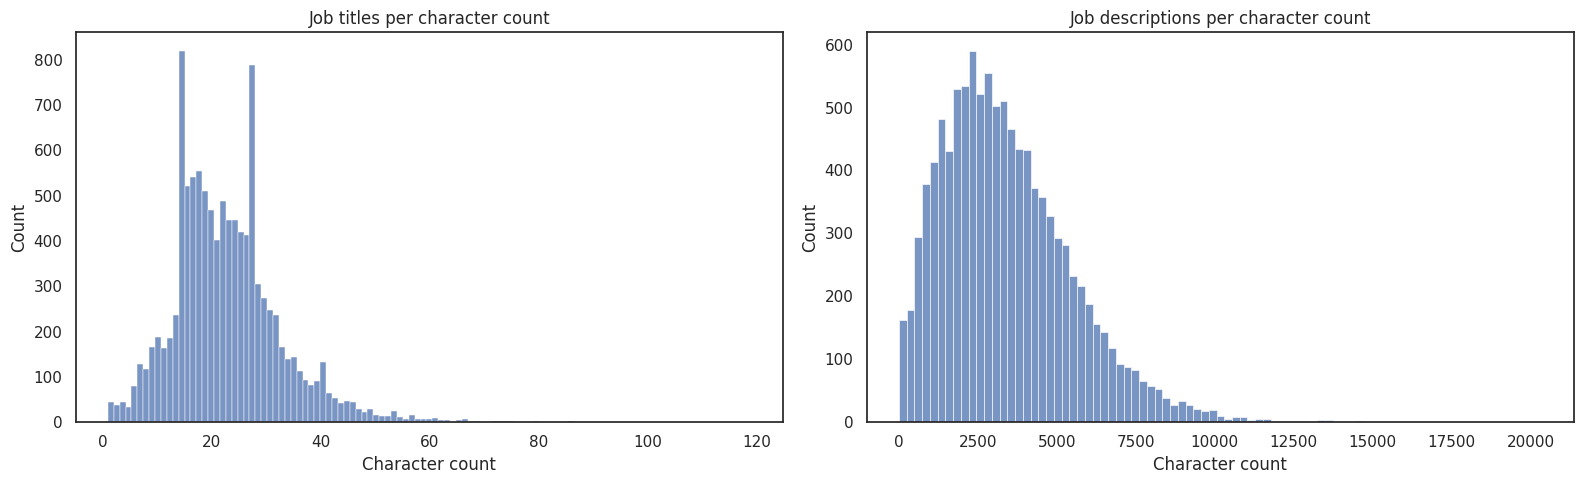

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Title - aka 'labels'
sns.histplot(data=df, x="title_len", ax=axes[0])
axes[0].set_title("Job titles per character count")
axes[0].set_xlabel("Character count")

# Description - aka 'features'
sns.histplot(data=df, x="description_len", ax=axes[1])
axes[1].set_title("Job descriptions per character count")
axes[1].set_xlabel("Character count")

fig.tight_layout()
plt.show()

## Word count

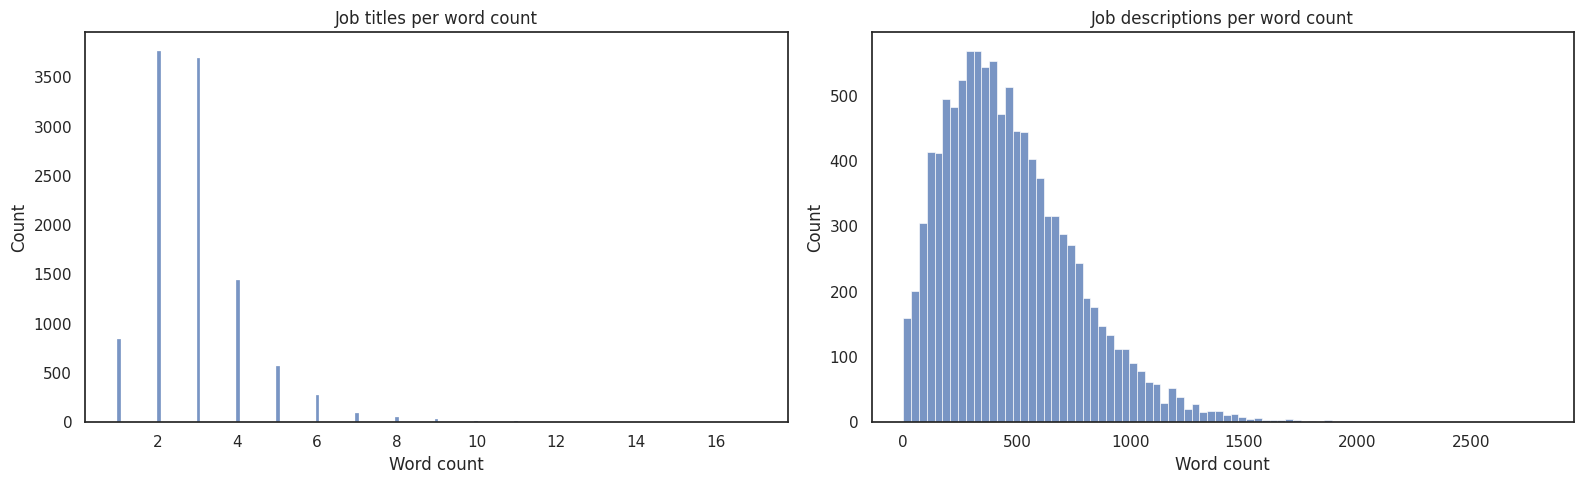

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Title - aka 'labels'
sns.histplot(data=df, x="title_n_words", ax=axes[0])
axes[0].set_title("Job titles per word count")
axes[0].set_xlabel("Word count")

# Description - aka 'features'
sns.histplot(data=df, x="description_n_words", ax=axes[1])
axes[1].set_title("Job descriptions per word count")
axes[1].set_xlabel("Word count")

fig.tight_layout()
plt.show()

## Correlation between length of titles and discriptions

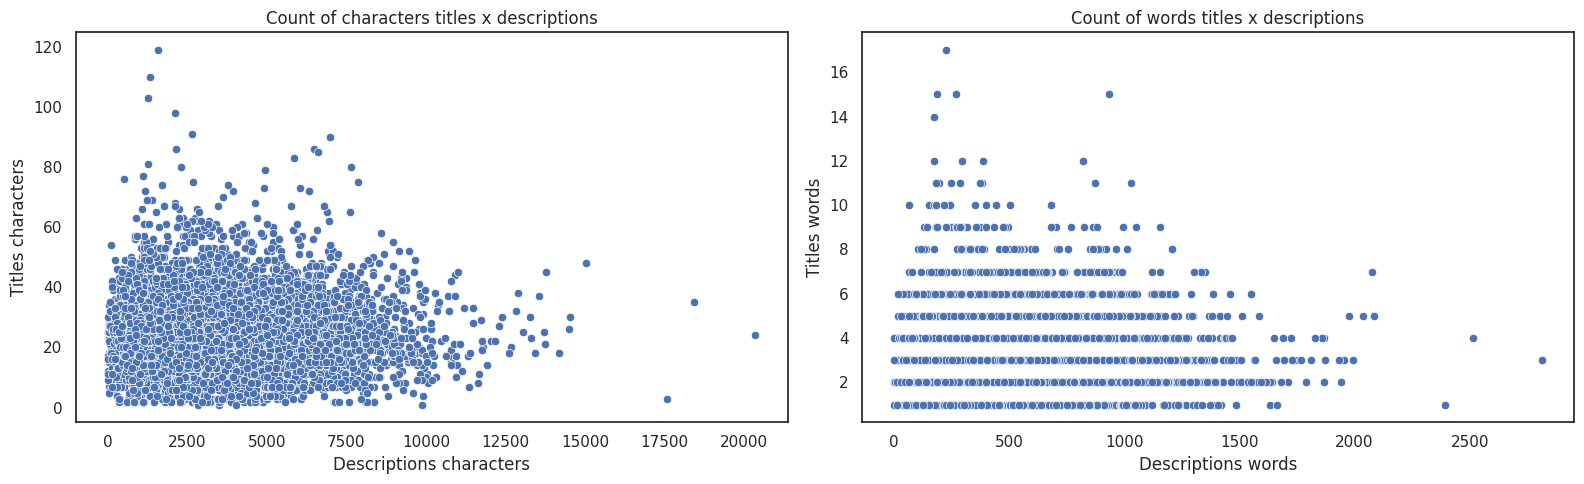

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Character count
sns.scatterplot(data=df, y="title_len", x="description_len", ax=axes[0])
axes[0].set_title("Count of characters titles x descriptions")
axes[0].set_xlabel("Descriptions characters")
axes[0].set_ylabel("Titles characters")

# Word count
sns.scatterplot(data=df, y="title_n_words", x="description_n_words", ax=axes[1])
axes[1].set_title("Count of words titles x descriptions")
axes[1].set_xlabel("Descriptions words")
axes[1].set_ylabel("Titles words")

fig.tight_layout()
plt.show()

In [30]:
df[["title_len", "description_len"]].corr()

,title_len,description_len
title_len,1.000000,0.064141
description_len,0.064141,1.000000


In [31]:
df[["title_n_words", "description_n_words"]].corr()

,title_n_words,description_n_words
title_n_words,1.000000,0.070044
description_n_words,0.070044,1.000000


#### Takeouts from basic EDA

It seems there's no strong correlation between the titles' and descriptions' sizes for both characters and words.

# BART Fine-tune

## Sampling from all data

This step is needed so we're able to fine-tune bart using Kaggle's infra.

In [32]:
df = df.sample(n=1_000, random_state=123, ignore_index=True).copy(deep=True)

## BART Base + Tokenizer

In [33]:
# Tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")

# Model
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

### Model size (MB)

In [34]:
# 32-bit model approximate size
# 1 Byte => 8 bits
# 32-bit (torch.float) => 4 Bytes
model_size = model.num_parameters() * 4 / (1024**2) # MB
print(f"Model size (MB): {model_size:,.3f}")

Model size (MB): 531.847


In [35]:
def compute_size(model):
    state_dict = model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:,.3f}")

compute_size(model)

Model size (MB) - 532.115


## Train/Val split

In [36]:
# Split into train/validation
train_df, val_df = train_test_split(df[["title", "description"]],
                                    test_size=.1,
                                    random_state=123)
print(f"Train DataFrame size: {train_df.shape}")
print(f"Val DataFrame size: {val_df.shape}")

Train DataFrame size: (900, 2)
Val DataFrame size: (100, 2)


In [37]:
sample = train_df.sample(1, random_state=123).squeeze()
sample_description = sample["description"]
sample_title = sample["title"]

tokens = tokenizer(sample_description, return_tensors="pt").to(device)
# Set a small length since the titles are small
output = model.generate(**tokens, max_length=10) 
output_text = tokenizer.batch_decode(output, skip_special_tokens=True)[0]
print(f"Original title: '{sample_title}'", "\n")
print(f"Generated: '{output_text}'")

Original title: 'Senior Accountant' 

Generated: 'Job Tag:  Posted: August'


### Dataset

In [38]:
train_set = Dataset.from_pandas(train_df,
                                preserve_index=False)

val_set = Dataset.from_pandas(val_df,
                              preserve_index=False)

In [39]:
train_set

Dataset({
    features: ['title', 'description'],
    num_rows: 900
})

## Tokenize function

In [40]:
def tokenize_func(sample):
    global tokenizer
    tokenized_sample = tokenizer(sample["description"],
                               truncation=True)
    tokenized_label = tokenizer(sample["title"],
                              truncation=True)
    tokenized_sample.update({"labels": tokenized_label["input_ids"]})
    return tokenized_sample

train_set_tokenized = train_set.map(tokenize_func, batched=True, remove_columns=["title", "description"])
val_set_tokenized = val_set.map(tokenize_func, batched=True, remove_columns=["title", "description"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

## ROUGE metric

In [41]:
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    global tokenizer, rouge
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

## Data collator

In [42]:
data_collator = DataCollatorForSeq2Seq(tokenizer, 
                                       padding=True,
                                       max_length=256,
                                       pad_to_multiple_of=8)

In [43]:
# Estimating train steps per epoch and total train steps
batch_size = 4
epochs = 10
grad_acc = 40
training_steps_per_epoch = int(np.ceil(len(train_set) / (batch_size * grad_acc))) - 1
training_steps = epochs * training_steps_per_epoch
print(f"Train steps: {training_steps}")
print(f"Steps per epoch: {training_steps_per_epoch}")
print(f"Train virtual batch_size: {batch_size * grad_acc}")

Train steps: 50
Steps per epoch: 5
Train virtual batch_size: 160


## Train args

In [44]:
train_args = Seq2SeqTrainingArguments(
    output_dir="bart-jobs-summarizer",
    seed=123,
    learning_rate=3e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=1e-2,
    num_train_epochs=10,
    fp16=True,
    gradient_accumulation_steps=40,
    warmup_steps=4,

    # Saving
    save_strategy="steps", # To use callbacks
    save_steps=2, # save_steps/eval_acc_steps - Save every 10/5 = 2 evaluations
    push_to_hub=False,

    # Callbacks
    load_best_model_at_end=True,
    metric_for_best_model="rougeL",

    # Eval
    do_eval=True,
    predict_with_generate=True,
    greater_is_better=True,
    evaluation_strategy="steps",
    logging_strategy="steps",
    logging_steps=1,
    eval_accumulation_steps=5, # Reduces memory consumptio during eval
    
    report_to="none", # Turn off WandB
)

### Early stop callback

In [45]:
early_stop_callback = EarlyStoppingCallback(5, 0.01)

## Optimizer: 8-bit Adam

In [46]:
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": train_args.weight_decay,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]

optimizer = bnb.optim.Adam8bit(optimizer_grouped_parameters, lr=train_args.learning_rate)

lr_scheduler = get_scheduler(
    name=train_args.lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=train_args.warmup_steps,
    num_training_steps=train_args.max_steps,
)

## Huggingface Trainer

In [47]:
trainer = Seq2SeqTrainer(model=model,
                         args=train_args,
                         train_dataset=train_set_tokenized,
                         eval_dataset=val_set_tokenized, 
                         tokenizer=tokenizer,
                         optimizers=(optimizer, lr_scheduler),
                         data_collator=data_collator, 
                         callbacks=[early_stop_callback], 
                         compute_metrics=compute_metrics)

### Train BART

In [48]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,5.894100,6.553396,0.140400,0.075300,0.136200,0.136500,19.970000
2,6.035300,6.553396,0.140400,0.075300,0.136200,0.136500,19.970000
3,5.845900,2.197766,0.390500,0.280600,0.383500,0.384800,11.490000
4,2.759800,2.197766,0.390500,0.280600,0.383500,0.384800,11.490000
5,2.858300,2.197766,0.390500,0.280600,0.383500,0.384800,11.490000
6,2.754600,2.923193,0.000000,0.000000,0.000000,0.000000,3.000000
7,4.355800,2.091577,0.532000,0.360000,0.529600,0.530600,6.010000
8,2.575800,2.091577,0.532000,0.360000,0.529600,0.530600,6.010000
9,2.364700,2.091577,0.532000,0.360000,0.529600,0.530600,6.010000
10,2.416800,2.091577,0.532000,0.360000,0.529600,0.530600,6.010000


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2436: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/opt

TrainOutput(global_step=13, training_loss=3.516104973279513, metrics={'train_runtime': 283.144, 'train_samples_per_second': 31.786, 'train_steps_per_second': 0.177, 'total_flos': 1119704788500480.0, 'train_loss': 3.516104973279513, 'epoch': 2.31})

## Check results

In [49]:
def generate_title(description: str) -> str:
    """
    Wrapper function to generate titles based
    on the provided descriptions.
    """
    tokens = tokenizer(description, return_tensors="pt").to(device)
    output = model.generate(**tokens, max_length=20)
    return tokenizer.batch_decode(output, skip_special_tokens=True)[0]

In [50]:
sample = val_df.sample(1, random_state=123).squeeze()
sample_description = sample["description"]
sample_title = sample["title"]

# Generate title
generated_title = generate_title(sample_description)

print(f"Original Title: {sample_title}")
print(f"{sample_description[:300]}...", "\n")
print(f"Generated Title: {generated_title}")

Original Title: Cost Accountant
Position: Cost Accountant  Reports to: President The CompanyWith double-digit annual growth rate since our founding in 1998, we are continuing to expand our dynamic team. As a contract manufacturer for in-vitro diagnostics, we make sure great products get made. The Natech learning organization devel... 

Generated Title: Cost Accountant


# Descriptions from LinkedIn

## Sample 1

Data extracted from LinkedIn by myself using their search engine.
- *Date extracted: 2023-10-10*
- **Company**: Kickstarter
- **Title**: Data Scientist
- Position link: [Link](https://www.linkedin.com/jobs/view/3734730928/?alternateChannel=search&refId=iktIOcPS2L8LN3%2FN5tEtOA%3D%3D&trackingId=2nrYiV3BEqtiPJIvnmmZ2A%3D%3D)

In [51]:
company = "Kickstarter"

title = "Data Scientist"

description = """Kickstarter, PBC is seeking a Data Scientist to join our Insights team.


The salary for this role in the United States is $110,000 - $130,000.


About The Team


Kickstarter's Insights team is a collaborative group of people who are passionate about using data and research to help bring creative projects to life. Our team's objectives include:


Democratizing data access across the organization and providing tools and training to support data-informed decisions;
Acquiring and synthesizing all relevant information about our ecosystem, the creative landscape, and our users, to provide high quality strategic advice to decision makers at all levels of the organization;
Raising the quality of data in our system, including improving our data infrastructure and modeling, and utilizing a variety of research methodologies to understand our users and their experiences. 


We value peer feedback, continuous learning, and blameless post-mortems. We prefer proven technology and have built most of our data infrastructure on AWS, but we also care about finding the right tools for the job, so we invest in cutting-edge technology when it's a good fit.


In This Role, You Will:


Query and analyze data in SQL for cross-functional stakeholders such as product managers, product designers, and engineers. 
Expand Kickstarter's business intelligence and product analytics capabilities to promote self-sufficiency throughout the organization. 
Conduct analyses in Python/R and communicate your findings to a diverse group of product stakeholders with both technical and non-technical backgrounds. 


About You


You have 2-5 years of professional experience in data analytics for a technical product. 
You are a SQL expert and proficient in Python or R. 
You are at ease conducting exploratory analysis and visualizing data. 
You have experience with A/B and multivariate testing. 
You value communicating insights concisely, accurately, and meaningfully to a diverse audience. 
Experience with dbt is a strong plus. 


What You'll Enjoy


A fully remote workforce with plenty of opportunities to get to know your colleagues
100% employer-paid health plan offerings
16 paid vacation days, 10 sick days, and a company-wide winter break between Christmas and New Years
25 volunteer hours each year to give back to your community
16 weeks of parental leave plus fertility/family planning resources
A 4-day/32-hour workweek! Kickstarter is currently experimenting with one so that we can all enjoy long weekends
Incredibly talented and inspiring colleagues who know how to blend their creative endeavors into their work


You can read more about our benefits and working at Kickstarter at our Jobs page: https://jobs.kickstarter.com/"""

In [52]:
generate_title(description)

'Data Scientist'